In [1]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from tqdm import tqdm
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fritt/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Part 1: Creating the sentiment dataframe

In [ ]:
df = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df = df.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2018-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))

In [ ]:
df.head()

**Changing the dataframe columns to their appropriate data types.**

In [ ]:
df.quoteID = df.quoteID.astype('string')
df.quotation = df.quotation.astype('string')
df.speaker = df.speaker.astype('string')
df.numOccurrences = df.numOccurrences.astype('int32')

In [ ]:
df.dtypes

In [ ]:
df = df.sort_values('date')
df.head()

In [ ]:
column_names = ['quoteID', 'quotation', 'speaker', 'date', 'numOccurrences','neg', 'neu', 'pos', 'compound']
    
sentiment_info_df = pd.DataFrame(columns = column_names)

print("Total number of rows: ", df.shape[0])
for idx, row in tqdm(df.iterrows()):
    
    # Calculating scores from SentimentIntensityAnalyzer
    new_row_dct = SentimentIntensityAnalyzer().polarity_scores(row['quotation'])
    
    # Creating and writing over value    
    new_row_dct['quoteID'] = row['quoteID']
    new_row_dct['quotation'] = row['quotation']
    new_row_dct['speaker'] = row['speaker']
    new_row_dct['date'] = row['date']
    new_row_dct['numOccurrences'] = row['numOccurrences']
    new_row = pd.DataFrame(new_row_dct, columns=column_names, index=[0])
    sentiment_info_df = sentiment_info_df.append(new_row)


In [ ]:
# Sorting by datetime
sentiment_info_df_sorted = sentiment_info_df.set_index('quoteID').sort_values('date')

# Clean the date column, such that it only contains date information and not timestamp
sentiment_info_df_sorted['date_clean'] = sentiment_info_df_sorted.apply(lambda x: x['date'][:10],axis=1)
sentiment_info_df_sorted.head()

In [ ]:
#sentiment_info_df_sorted.to_csv('./data/sentiment_df.csv')

## Part 2: Sentiment analysis

In [2]:
# Read from csv to recreate a the fresh dataframe
sentiment_df = pd.read_csv('./data/sentiment_df.csv')
#finding index of outlier
print(sentiment_df[sentiment_df.numOccurrences == 39978])
#removing outlier
sentiment_df = sentiment_df.drop(58674)

                 quoteID                                          quotation  \
58674  2018-05-02-028818  Fortnite for iPhone is something of a gem in t...   

      speaker                 date  numOccurrences  neg  neu  pos  compound  \
58674    None  2018-05-02 14:18:00           39978  0.0  1.0  0.0       0.0   

       date_clean  
58674  2018-05-02  


**Raw datapoints visualized:**  
Firstly we will visualize the datapoints for positive and negative tweets, these tweets will need a treshold of at least +/- 0.6 to ensure that we don't register all the neutral tweets.  
- Green points: positive tweets
- Red points: negative tweets

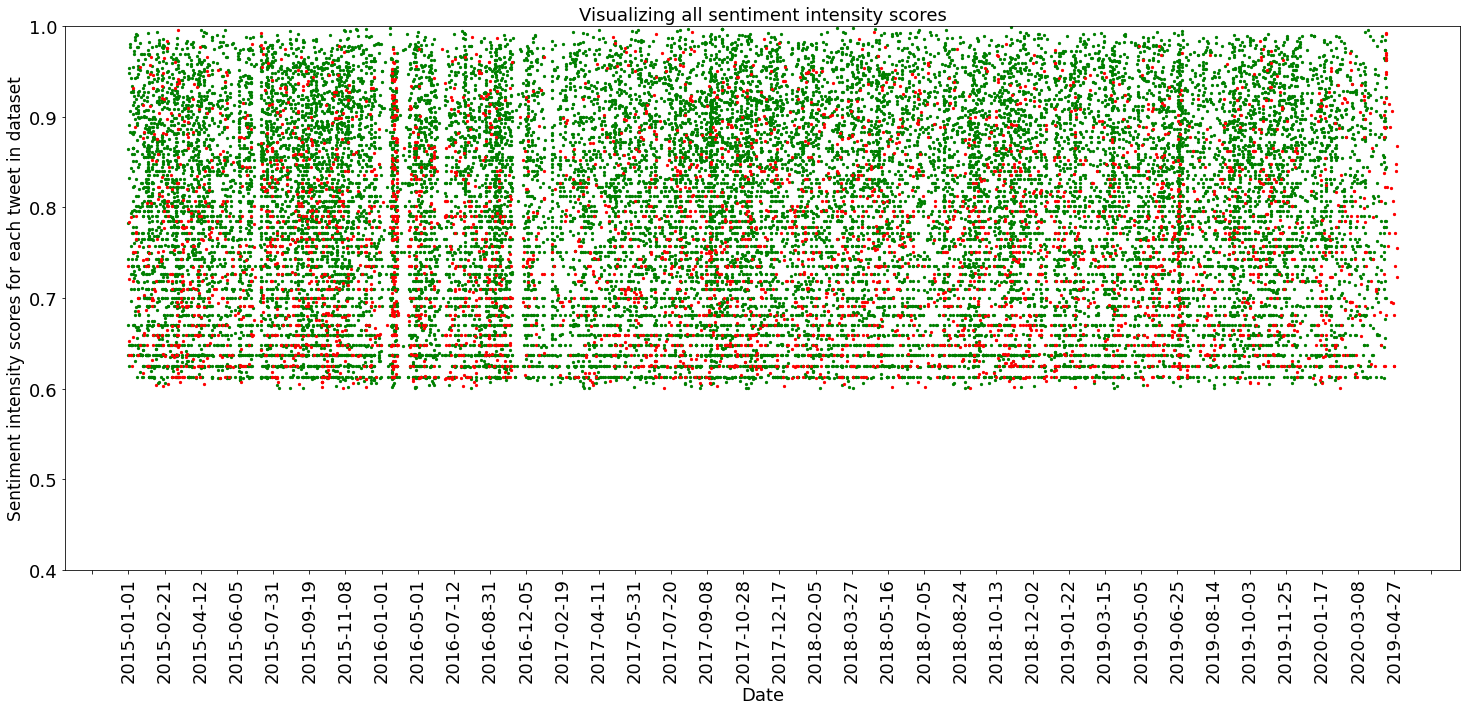

In [3]:
fig,ax = plt.subplots(figsize=(25,10))

cutoff_decimal = 0.6


pos_scores_df = sentiment_df[sentiment_df['compound'] > cutoff_decimal]
pos_scores = pos_scores_df['compound']
pos_dates = pos_scores_df['date_clean']

neg_scores_df = sentiment_df[sentiment_df['compound'] < -cutoff_decimal]
neg_scores = -neg_scores_df['compound']
neg_dates = neg_scores_df['date_clean']
ax.set_ylim([0.4,1])
ax.scatter(pos_dates, pos_scores, s=5, color='green')
ax.scatter(neg_dates, neg_scores, s=5, color='red')

loc = plticker.MultipleLocator(base=50) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.title('Visualizing all sentiment intensity scores', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sentiment intensity scores for each tweet in dataset', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.xticks(rotation=90)
plt.show()

This visualization is mainly to get a feeling of how to points are distributed, but it won't give us a lot of information straight away. It is just too much information for a human being to interpret, we will therefore make an aggregated graph based on the positive and negative points.  

The positive tweets will account for their value (given from SentimentIntensityAnalyzer) multiplied by +1.  
The negative tweets will account for their value (given from SentimentIntensityAnalyzer) multiplied by -1.

In [4]:
# Try aggregate on weekly values, i.e. 7 days
# Based on how much they contribute increase size of scatter plot circle
agg_month_sentiment = []
agg_month_dates = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_month = date[:7]
        current_size = 0


    tmp_month = current_month
    current_month = date[:7] # the seven first digits of the date
    if tmp_month != current_month:
        agg_month_sentiment.append(current_size)
        current_size = 0
        agg_month_dates.append(current_month)
    
    # updates weighted aggregated value of positive and negative
    current_size += row['compound']*row['numOccurrences']

    
    

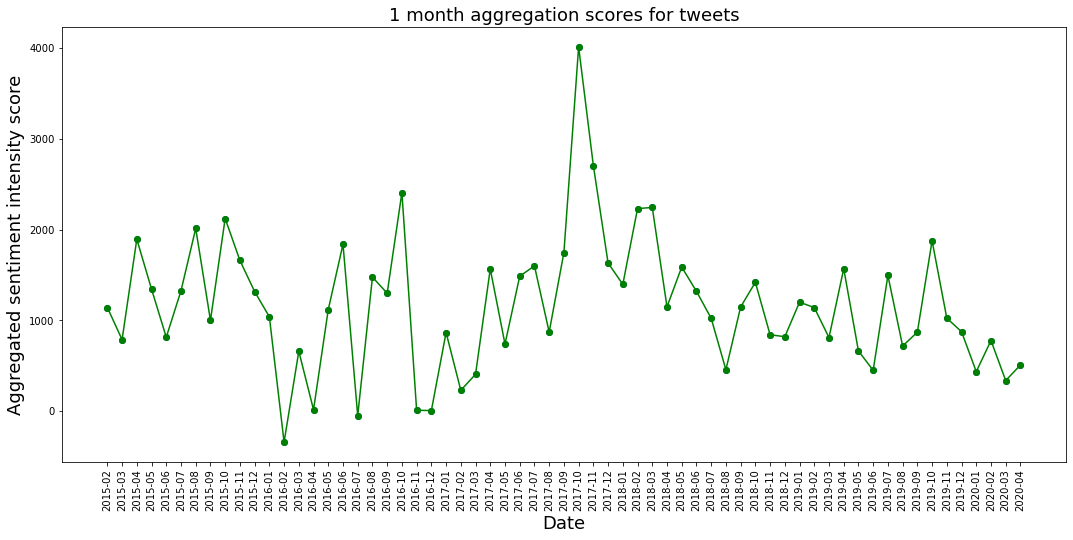

In [5]:
fig,ax = plt.subplots(figsize=(18,8))
result_values = []
result_mon = []
for mon, agg in zip(agg_month_dates, agg_month_sentiment):
    result_values.append(agg)
    result_mon.append(mon)

        

ax.scatter(result_mon, result_values)

ax.plot(result_mon, result_values, '-o', color='green')
plt.title('1 month aggregation scores for tweets', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Aggregated sentiment intensity score', fontsize=18)

#ax.plot(agg_month_dates, agg_month_sentiment)
plt.xticks(rotation=90);

## Additional added weight to each quote (based on speaker)
**Name list - multiplicative weight:**
1. Tim Cook  - 2.0
2. Steve Jobs - 1.9
3. Eddy Cue - 1.8
4. Jony Ive - 1.7
5. Donald Trump - 1.6
6. Phill Schiller - 1.5
7. Jeff Williams - 1.4
8. Steve Wozniak - 1.3
9. Ben Wood  -  1.2
10. Brian White  - 1.1

Based on our "Most frequently quoted speakers about Apple" bar chart race, we will give quotes that has a speaker to any of the people from the top 10 list some additional weight. 

In [8]:
speaker_weights = {
    "Tim Cook": 2,
    "Steve Jobs": 1.9,
     "Eddy Cue" : 1.8,
     "Jony Ive" : 1.7,
     "Donald Trump" : 1.6,
     "Phill Schiller" : 1.5,
     "Jeff Williams" : 1.4,
     "Steve Wozniak" : 1.3,
     "Ben Wood" : 1.2,
     "Brian White" : 1.1,
}

In [12]:
# Try aggregate on weekly values, i.e. 7 days
# Based on how much they contribute increase size of scatter plot circle
agg_month_sentiment = []
agg_month_dates = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    speaker = row['speaker']
    if index == 0:
        current_month = date[:7]
        current_size = 0


    tmp_month = current_month
    current_month = date[:7] # the seven first digits of the date
    if tmp_month != current_month:
        agg_month_sentiment.append(current_size)
        current_size = 0
        agg_month_dates.append(current_month)
    
    speaker_mult = 1
    if speaker in speaker_weights:
        speaker_mult = speaker_weights[speaker]
        
    # updates weighted aggregated value of positive and negative
    current_size += row['compound']*row['numOccurrences']*speaker_mult

    
    

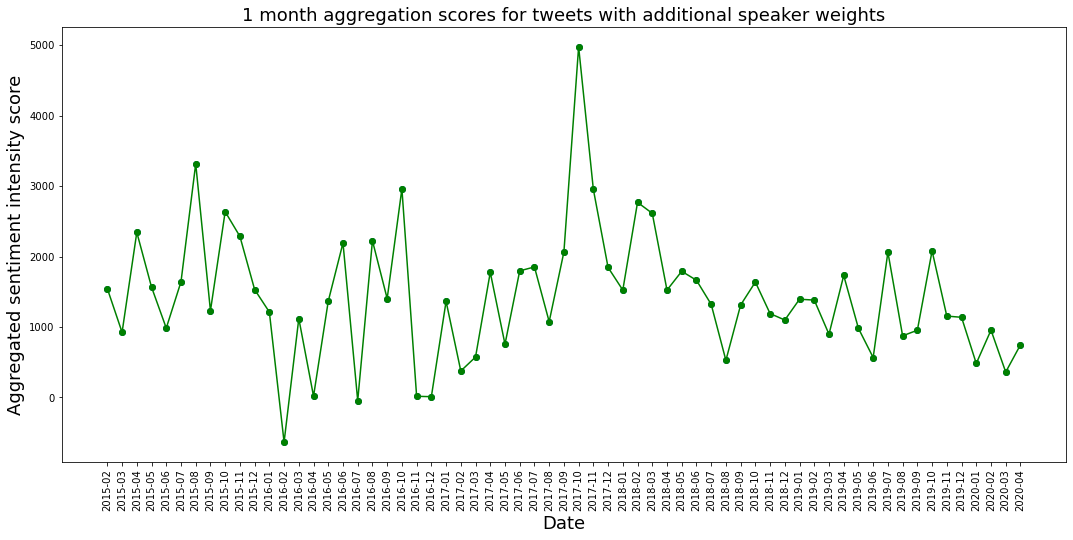

In [13]:
fig,ax = plt.subplots(figsize=(18,8))
result_values = []
result_mon = []
for mon, agg in zip(agg_month_dates, agg_month_sentiment):
    result_values.append(agg)
    result_mon.append(mon)

        

ax.scatter(result_mon, result_values)

ax.plot(result_mon, result_values, '-o', color='green')
plt.title('1 month aggregation scores for tweets with additional speaker weights', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Aggregated sentiment intensity score', fontsize=18)

#ax.plot(agg_month_dates, agg_month_sentiment)
plt.xticks(rotation=90);